In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from moepy import surface, moe

import pickle
from sklearn.metrics import r2_score
from moepy.surface import PicklableFunction

import FEAutils as hlp

In [2]:
models_dir = '../data/models'

<br>

### Germany

In [3]:
df_fuels_DE = pd.read_csv('../data/energy_charts.csv')

df_fuels_DE = df_fuels_DE.set_index('local_datetime')
df_fuels_DE.index = pd.to_datetime(df_fuels_DE.index, utc=True).tz_convert('Europe/Berlin')

df_fuels_DE.head()

,Biomass,Brown Coal,Gas,Hard Coal,Hydro Power,Oil,Others,Pumped Storage,Seasonal Storage,Solar,Uranium,Wind,net_balance
local_datetime,,,,,,,,,,,,,
2010-01-04 00:00:00+01:00,3.637,16.533,4.726,10.078,2.331,0.000,0.0,0.052,0.068,0.0,16.826,0.635,-1.229
2010-01-04 01:00:00+01:00,3.637,16.544,4.856,8.816,2.293,0.000,0.0,0.038,0.003,0.0,16.841,0.528,-1.593
2010-01-04 02:00:00+01:00,3.637,16.368,5.275,7.954,2.299,0.000,0.0,0.032,0.000,0.0,16.846,0.616,-1.378
2010-01-04 03:00:00+01:00,3.637,15.837,5.354,7.681,2.299,0.000,0.0,0.027,0.000,0.0,16.699,0.630,-1.624
2010-01-04 04:00:00+01:00,3.637,15.452,5.918,7.498,2.301,0.003,0.0,0.020,0.000,0.0,16.635,0.713,-0.731


<AxesSubplot:ylabel='Count'>

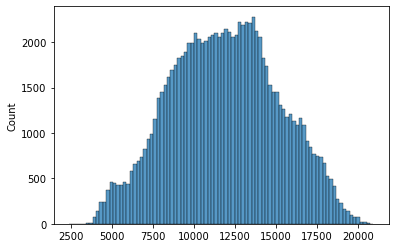

In [4]:
# https://www.volker-quaschning.de/datserv/CO2-spez/index_e.php
# should specify that I'm looking at the fuel emissions (not avg over lifecycle incl CAPEX)
# the units are kgCO2 / kWh, same as Tonnes/MWh 

DE_fuel_to_co2_intensity = {
    'Biomass': 0.39, 
    'Brown Coal': 0.36, 
    'Gas': 0.23, 
    'Hard Coal': 0.34, 
    'Hydro Power': 0, 
    'Oil': 0.28,
    'Others': 0, 
    'Pumped Storage': 0, 
    'Seasonal Storage': 0, 
    'Solar': 0, 
    'Uranium': 0,
    'Wind': 0, 
    'net_balance': 0 
}

s_DE_emissions_tonnes = (df_fuels_DE
                         .multiply(1e3) # converting to MWh
                         [DE_fuel_to_co2_intensity.keys()]
                         .multiply(DE_fuel_to_co2_intensity.values())
                         .sum(axis=1)
                        )

s_DE_emissions_tonnes = s_DE_emissions_tonnes[s_DE_emissions_tonnes>2000]

sns.histplot(s_DE_emissions_tonnes)

Text(0, 0.5, 'CO2 Emissions (Tonnes)')

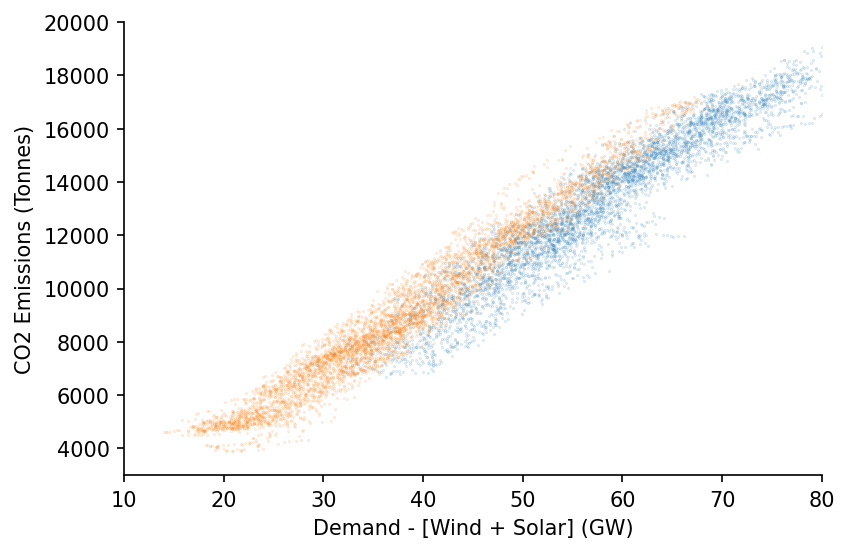

In [5]:
df_DE = pd.DataFrame({
    'demand': df_fuels_DE.sum(axis=1),
    'dispatchable': df_fuels_DE.drop(columns=['Solar', 'Wind']).sum(axis=1),
    'emissions': s_DE_emissions_tonnes
}).dropna()

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_DE.loc['2010-09':'2011-03', 'dispatchable'], df_DE.loc['2010-09':'2011-03', 'emissions'], s=0.1, alpha=0.25)
ax.scatter(df_DE.loc['2019-09':'2020-03', 'dispatchable'], df_DE.loc['2019-09':'2020-03', 'emissions'], s=0.1, alpha=0.25)

hlp.hide_spines(ax)
ax.set_xlim(10, 80)
ax.set_ylim(3000, 20000)
ax.set_xlabel('Demand - [Wind + Solar] (GW)')
ax.set_ylabel('CO2 Emissions (Tonnes)')

<br>

### Great Britain 

We'll now do the same for the GB system

In [6]:
df_fuels_GB = pd.read_csv('../data/electric_insights.csv')

df_fuels_GB = df_fuels_GB.set_index('local_datetime')
df_fuels_GB.index = pd.to_datetime(df_fuels_GB.index, utc=True).tz_convert('Europe/Berlin')

df_fuels_GB.head()

,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 01:00:00+01:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 01:30:00+01:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 02:00:00+01:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 02:30:00+01:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 03:00:00+01:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

<img src="../img/docs/GB DUKES carbon intensity.png" width="600">

<AxesSubplot:ylabel='Count'>

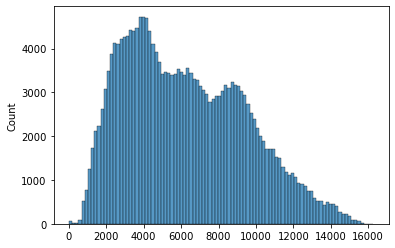

In [7]:
GB_fuel_to_co2_intensity = {
    'nuclear': 0, 
    'biomass': 0.121, # from EI 
    'coal': 0.921, # DUKES 2018 value
    'gas': 0.377, # DUKES 2018 value (lower than many CCGT estimates, let alone OCGT)
    'hydro': 0, 
    'pumped_storage': 0, 
    'solar': 0,
    'wind': 0,
    'belgian': 0.4,  
    'dutch': 0.474, # from EI 
    'french': 0.053, # from EI 
    'ireland': 0.458, # from EI 
    'northern_ireland': 0.458 # from EI 
}

s_GB_emissions_tonnes = (df_fuels_GB
                         .multiply(1e3*0.5) # converting to MWh
                         [GB_fuel_to_co2_intensity.keys()]
                         .multiply(GB_fuel_to_co2_intensity.values())
                         .sum(axis=1)
                        )

sns.histplot(s_GB_emissions_tonnes)

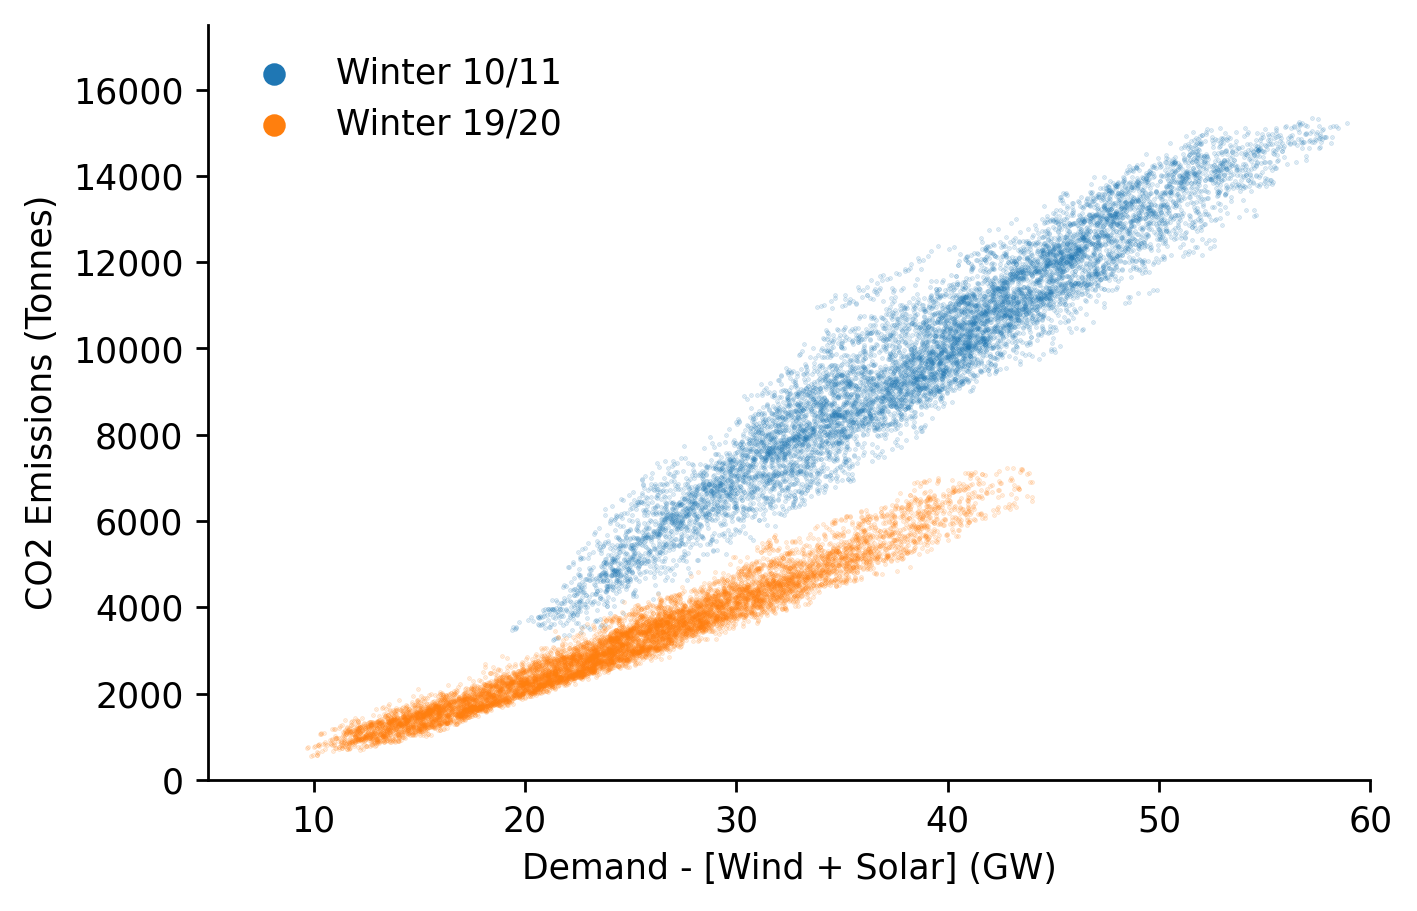

In [8]:
df_GB = pd.DataFrame({
    'demand': df_fuels_GB[GB_fuel_to_co2_intensity.keys()].sum(axis=1),
    'dispatchable': df_fuels_GB[GB_fuel_to_co2_intensity.keys()].drop(columns=['solar', 'wind']).sum(axis=1),
    'emissions': s_GB_emissions_tonnes
}).dropna()

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(df_GB.loc['2010-09':'2011-03', 'dispatchable'], df_GB.loc['2010-09':'2011-03', 'emissions'], s=0.1, alpha=0.25, label='Winter 10/11')
ax.scatter(df_GB.loc['2019-09':'2020-03', 'dispatchable'], df_GB.loc['2019-09':'2020-03', 'emissions'], s=0.1, alpha=0.25, label='Winter 19/20')

hlp.hide_spines(ax)
ax.set_xlim(5, 60)
ax.set_ylim(0, 17500)
ax.set_xlabel('Demand - [Wind + Solar] (GW)')
ax.set_ylabel('CO2 Emissions (Tonnes)')

lgnd = ax.legend(frameon=False) # Need to increase the legend marker size
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

for lh in lgnd.legendHandles: 
    lh.set_alpha(1)

<br>

### Model Fitting

In [9]:
model_definitions = {
    'carbon_emissions_DE': {
        'dt_idx': df_DE.index,
        'x': df_DE['dispatchable'].values,
        'y': df_DE['emissions'].values,
        'reg_dates_start': '2010-01-04',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': surface.get_fit_kwarg_sets(qs=[0.16, 0.5, 0.84])
    },
    'carbon_emissions_GB': {
        'dt_idx': df_GB.index,
        'x': df_GB['dispatchable'].values,
        'y': df_GB['emissions'].values,
        'reg_dates_start': '2010-01-04',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': surface.get_fit_kwarg_sets(qs=[0.16, 0.5, 0.84])
    }
}

surface.fit_models(model_definitions, models_dir)

carbon_emission [█████████████████████████████████████████████] 4/4 [00:00<00:00, 0.00s/it]

carbon_emission [█████████████████████████████████████████████] 4/4 [00:00<00:00, 0.00s/it]

<br>

### German Carbon Savings Calculations

In [10]:
%%time

DE_model_fp = '../data/models/carbon_emissions_DE_p50.pkl'
DE_smooth_dates = pickle.load(open(DE_model_fp, 'rb'))

DE_x_pred = np.linspace(-5, 91, 961)
DE_dt_pred = pd.date_range('2010-01-01', '2020-12-31', freq='D')

df_DE_pred = DE_smooth_dates.predict(x_pred=DE_x_pred, dt_pred=DE_dt_pred)
df_DE_pred.index = np.round(df_DE_pred.index, 1)

df_DE_pred.head()

Wall time: 5.03 s


,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
-5.0,3886.653832,3879.821665,3873.016902,3866.240361,3859.492840,3852.775114,3846.087938,3839.432046,3832.808148,3826.216939,...,90.996727,89.607262,88.211213,86.808112,85.397465,83.978746,82.551516,81.115786,79.671679,78.219325
-4.9,3892.076989,3885.264247,3878.478942,3871.721888,3864.993880,3858.295688,3851.628062,3844.991733,3838.387409,3831.815777,...,109.687487,108.304289,106.914538,105.517769,104.113489,102.701176,101.280394,99.851151,98.413572,96.967786
-4.8,3897.575235,3890.781146,3884.014533,3877.276206,3870.566953,3863.887542,3857.238720,3850.621212,3844.035723,3837.482937,...,128.390414,127.013480,125.630025,124.239585,122.841670,121.435761,120.021423,118.598666,117.167613,115.728392
-4.7,3903.139760,3896.363657,3889.615072,3882.894811,3876.203659,3869.542378,3862.911712,3856.312382,3849.745088,3843.210513,...,147.104928,145.734256,144.357093,142.972980,141.581429,140.181921,138.774026,137.357751,135.933222,134.500564
-4.6,3908.729326,3901.970862,3895.239960,3888.537422,3881.864029,3875.220541,3868.607694,3862.026209,3855.476780,3848.960087,...,165.827770,164.463359,163.092488,161.714700,160.329510,158.936402,157.534947,156.125155,154.707147,153.281051


C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Text(69.58333333333334, 0.5, 'Demand - [Solar + Wind] (GW)')

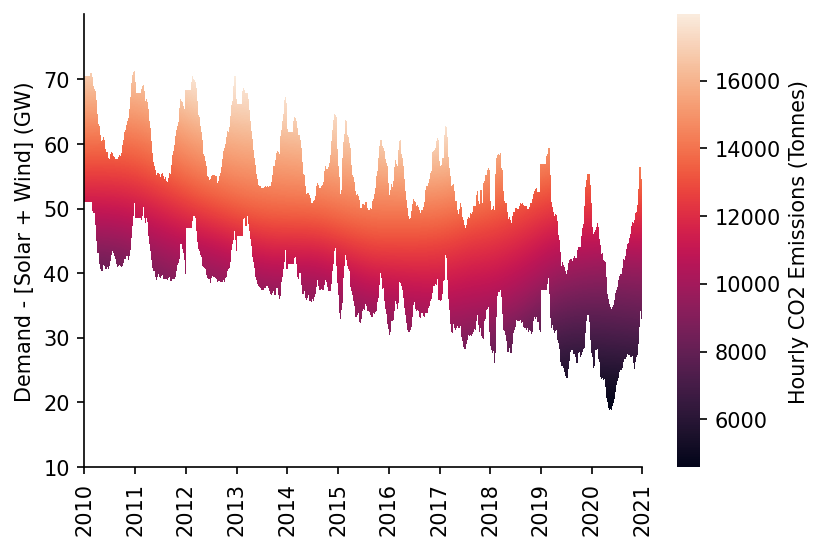

In [11]:
df_DE_dispatchable_lims = moe.construct_dispatchable_lims_df(df_DE['dispatchable'], rolling_w=6)
df_DE_pred_mask = moe.construct_pred_mask_df(df_DE_pred, df_DE_dispatchable_lims)

# Plotting
min_y = 10
max_y = 80
fig, ax = plt.subplots(dpi=150)

htmp = sns.heatmap(df_DE_pred[min_y:max_y].where(df_DE_pred_mask[min_y:max_y], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Hourly CO2 Emissions (Tonnes)'})

moe.set_ticks(ax, np.arange(min_y, max_y, 10), axis='y')
moe.set_date_ticks(ax, '2010-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
hlp.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

In [12]:
s_DE_pred_ts_dispatch, s_DE_pred_ts_demand = moe.get_model_pred_ts(df_DE['dispatchable'], DE_model_fp, s_demand=df_DE['demand'], x_pred=DE_x_pred, dt_pred=DE_dt_pred)
s_DE_err = s_DE_pred_ts_dispatch - df_DE.loc[s_DE_pred_ts_dispatch.index, 'emissions']
metrics = moe.calc_error_metrics(s_DE_err)

metrics

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 96191/96191 [02:23<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 96191/96191 [02:28<00:00, 0.00s/it]

{'median_abs_err': 603.7669189236494,
 'mean_abs_err': 750.7665511092414,
 'root_mean_square_error': 967.8069705064318}

In [13]:
r2_score(df_DE.loc[s_DE_pred_ts_dispatch.index, 'emissions'], s_DE_pred_ts_dispatch)

0.9139682818721121

In [14]:
start_date = '2010'
end_date = '2020'

s_DE_MOE = s_DE_pred_ts_demand - s_DE_pred_ts_dispatch
s_DE_MOE = s_DE_MOE.dropna()

total_saving = s_DE_MOE[start_date:end_date].sum()

print(f"The total saving between {start_date} and {end_date} was {total_saving:,.0f} Tonnes")

The total saving between 2010 and 2020 was 318,923,308 Tonnes


In [15]:
s_DE_emissions = df_DE['emissions'].loc[s_DE_MOE.index]

avg_DE_HH_emissions = s_DE_emissions.mean()
total_DE_emissions = s_DE_emissions[start_date:end_date].sum()

avg_DE_HH_emissions, total_DE_emissions

(11870.320551662837, 1141818004.185)

In [16]:
total_saving/(total_DE_emissions+total_saving)

0.21832976535024085

<AxesSubplot:xlabel='local_datetime'>

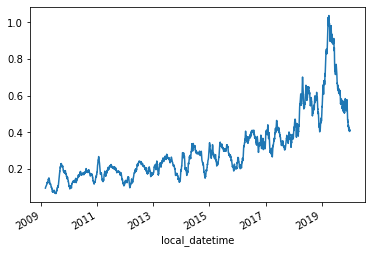

In [17]:
s_DE_emissions_rolling = s_DE_emissions.rolling(48*28).mean().dropna()
s_DE_MOE_rolling = s_DE_MOE.rolling(48*28).mean().dropna()

s_DE_MOE_pct_reduction = s_DE_MOE_rolling/s_DE_emissions_rolling

s_DE_MOE_pct_reduction.plot()

<br>

### British Carbon Savings Calculations

In [18]:
%%time

start_date = '2010-01-01'
end_date = '2020-12-31'

GB_model_fp = '../data/models/carbon_emissions_GB_p50.pkl'
GB_smooth_dates = pickle.load(open(GB_model_fp, 'rb'))

GB_x_pred = np.linspace(-5, 91, 961)
GB_dt_pred = pd.date_range(start_date, end_date, freq='D')

df_GB_pred = GB_smooth_dates.predict(x_pred=GB_x_pred, dt_pred=GB_dt_pred)
df_GB_pred.index = np.round(df_GB_pred.index, 1)

df_GB_pred.head()

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:68: RuntimeWarning: invalid value encountered in true_divide
  weights = weights/weights.sum(axis=0) # We'll then normalise the weights so that for each model they sum to 1 for a single data point


Wall time: 8.07 s


,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
-5.0,-3464.318328,-3464.498638,-3464.677421,-3464.854668,-3465.030374,-3465.204532,-3465.377135,-3465.548177,-3465.717654,-3465.885560,...,-1132.671694,-1132.645477,-1132.619826,-1132.594469,-1132.569124,-1132.543491,-1132.517311,-1132.490526,-1132.463132,-1132.435123
-4.9,-3439.998589,-3440.165216,-3440.330434,-3440.494235,-3440.656614,-3440.817564,-3440.977080,-3441.135157,-3441.291788,-3441.446970,...,-1119.725619,-1119.699568,-1119.674080,-1119.648887,-1119.623704,-1119.598235,-1119.572221,-1119.545603,-1119.518379,-1119.490541
-4.8,-3415.639932,-3415.793033,-3415.944841,-3416.095351,-3416.244555,-3416.392450,-3416.539028,-3416.684287,-3416.828220,-3416.970823,...,-1106.780192,-1106.754304,-1106.728978,-1106.703945,-1106.678922,-1106.653614,-1106.627762,-1106.601309,-1106.574251,-1106.546582
-4.7,-3391.243054,-3391.382783,-3391.521334,-3391.658702,-3391.794883,-3391.929870,-3392.063659,-3392.196245,-3392.327625,-3392.457792,...,-1093.835446,-1093.809719,-1093.784551,-1093.759675,-1093.734810,-1093.709660,-1093.683967,-1093.657676,-1093.630782,-1093.603278
-4.6,-3366.808409,-3366.934917,-3367.060362,-3367.184739,-3367.308043,-3367.430270,-3367.551415,-3367.671473,-3367.790442,-3367.908316,...,-1080.891348,-1080.865779,-1080.840767,-1080.816046,-1080.791335,-1080.766340,-1080.740805,-1080.714672,-1080.687938,-1080.660597


C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Text(69.58333333333334, 0.5, 'Demand - [Solar + Wind] (GW)')

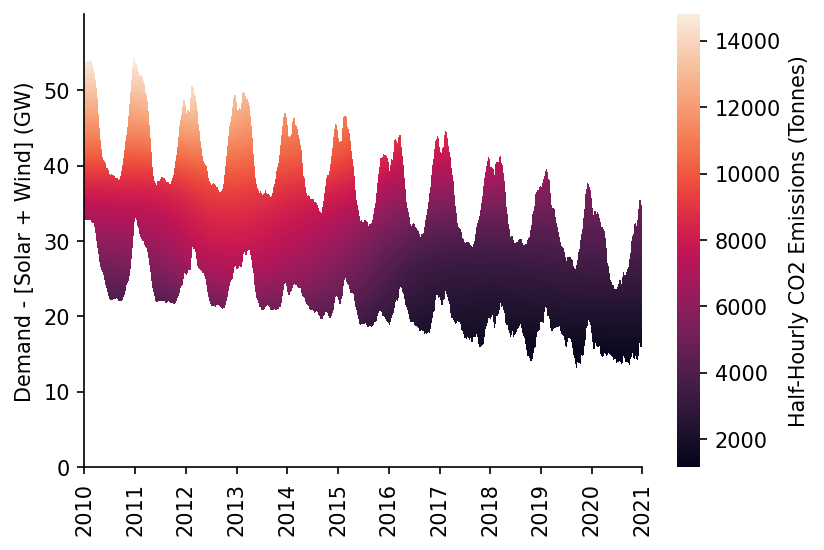

In [19]:
df_GB_dispatchable_lims = moe.construct_dispatchable_lims_df(df_GB.loc[start_date:end_date, 'dispatchable'], rolling_w=6)
df_GB_pred_mask = moe.construct_pred_mask_df(df_GB_pred, df_GB_dispatchable_lims)

# Plotting
min_y = 0
max_y = 60
fig, ax = plt.subplots(dpi=150)

htmp = sns.heatmap(df_GB_pred[min_y:max_y].where(df_GB_pred_mask[min_y:max_y], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Half-Hourly CO2 Emissions (Tonnes)'})

moe.set_ticks(ax, np.arange(min_y, max_y, 10), axis='y')
moe.set_date_ticks(ax, '2010-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
hlp.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

In [20]:
s_GB_pred_ts_dispatch, s_GB_pred_ts_demand = moe.get_model_pred_ts(df_GB['dispatchable'], GB_model_fp, s_demand=df_GB['demand'], x_pred=GB_x_pred, dt_pred=GB_dt_pred)
s_GB_err = s_GB_pred_ts_dispatch - df_GB.loc[s_GB_pred_ts_dispatch.index, 'emissions']
metrics = moe.calc_error_metrics(s_GB_err)

metrics

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:68: RuntimeWarning: invalid value encountered in true_divide
  weights = weights/weights.sum(axis=0) # We'll then normalise the weights so that for each model they sum to 1 for a single data point
C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 192336/192336 [03:52<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 192336/192336 [04:10<00:00, 0.00s/it]

{'median_abs_err': 330.24369388573996,
 'mean_abs_err': 476.21722650533655,
 'root_mean_square_error': 661.7182203091455}

In [21]:
r2_score(df_GB.loc[s_GB_pred_ts_dispatch.index, 'emissions']*2, s_GB_pred_ts_dispatch)

-0.22263290223370658

In [22]:
s_GB_MOE = s_GB_pred_ts_demand - s_GB_pred_ts_dispatch
s_GB_MOE = s_GB_MOE.dropna()

total_saving = s_GB_MOE[start_date:end_date].sum()

print(f"The total saving between {start_date} and {end_date} was {total_saving:,.0f} Tonnes")

The total saving between 2010-01-01 and 2020-12-31 was 221,069,470 Tonnes


In [23]:
s_GB_emissions = df_GB['emissions'].loc[s_GB_MOE.index]

avg_GB_HH_emissions = s_GB_emissions.mean()
total_GB_emissions = s_GB_emissions[start_date:end_date].sum()

avg_GB_HH_emissions, total_GB_emissions

(6034.469929827791, 1160645808.423358)

In [24]:
total_saving/(total_GB_emissions+total_saving)

0.15999639957299291

<AxesSubplot:xlabel='local_datetime'>

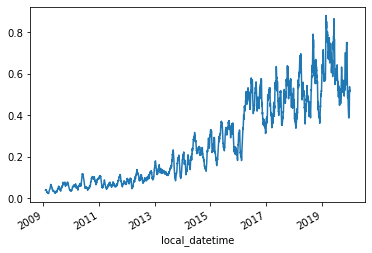

In [25]:
s_GB_emissions_rolling = s_GB_emissions.rolling(48*28).mean().dropna()
s_GB_MOE_rolling = s_GB_MOE.rolling(48*28).mean().dropna()

s_GB_MOE_pct_reduction = s_GB_MOE_rolling/s_GB_emissions_rolling

s_GB_MOE_pct_reduction.plot()

<br>

### Plots

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


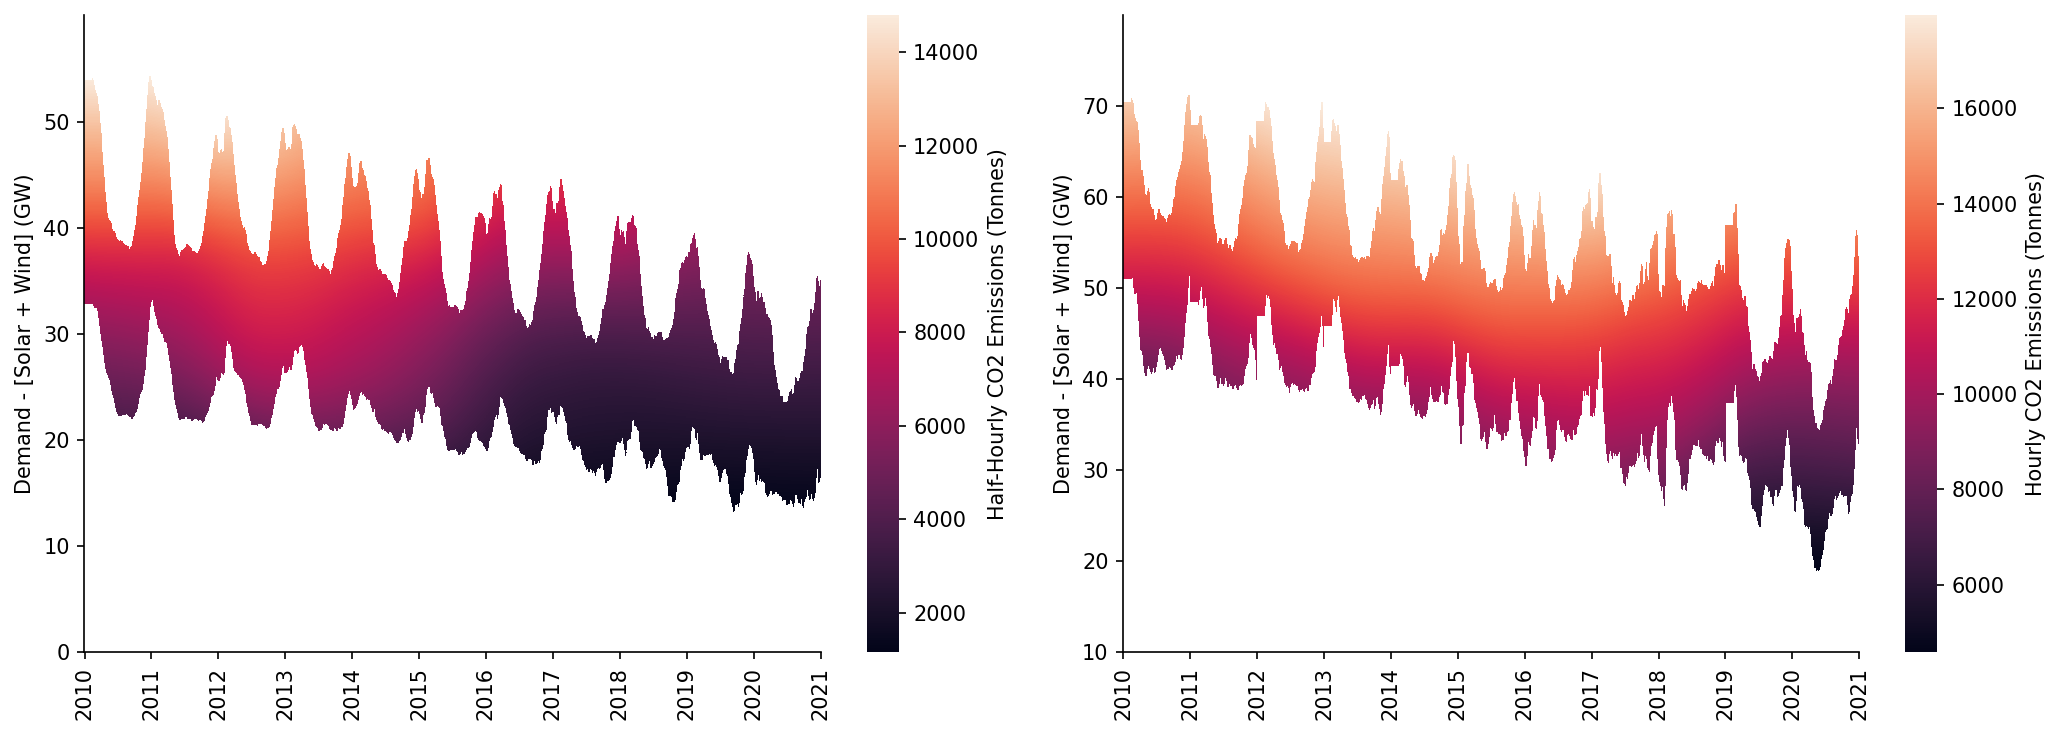

In [26]:
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(14, 5))

# GB
ax = axs[0]
min_y = 0
max_y = 60

htmp = sns.heatmap(df_GB_pred[min_y:max_y].where(df_GB_pred_mask[min_y:max_y], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Half-Hourly CO2 Emissions (Tonnes)'})

moe.set_ticks(ax, np.arange(min_y, max_y, 10), axis='y')
moe.set_date_ticks(ax, '2010-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
hlp.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

# DE
ax = axs[1]
min_y = 10
max_y = 80

htmp = sns.heatmap(df_DE_pred[min_y:max_y].where(df_DE_pred_mask[min_y:max_y], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Hourly CO2 Emissions (Tonnes)'})

moe.set_ticks(ax, np.arange(min_y, max_y, 10), axis='y')
moe.set_date_ticks(ax, '2010-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
hlp.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

fig.tight_layout()

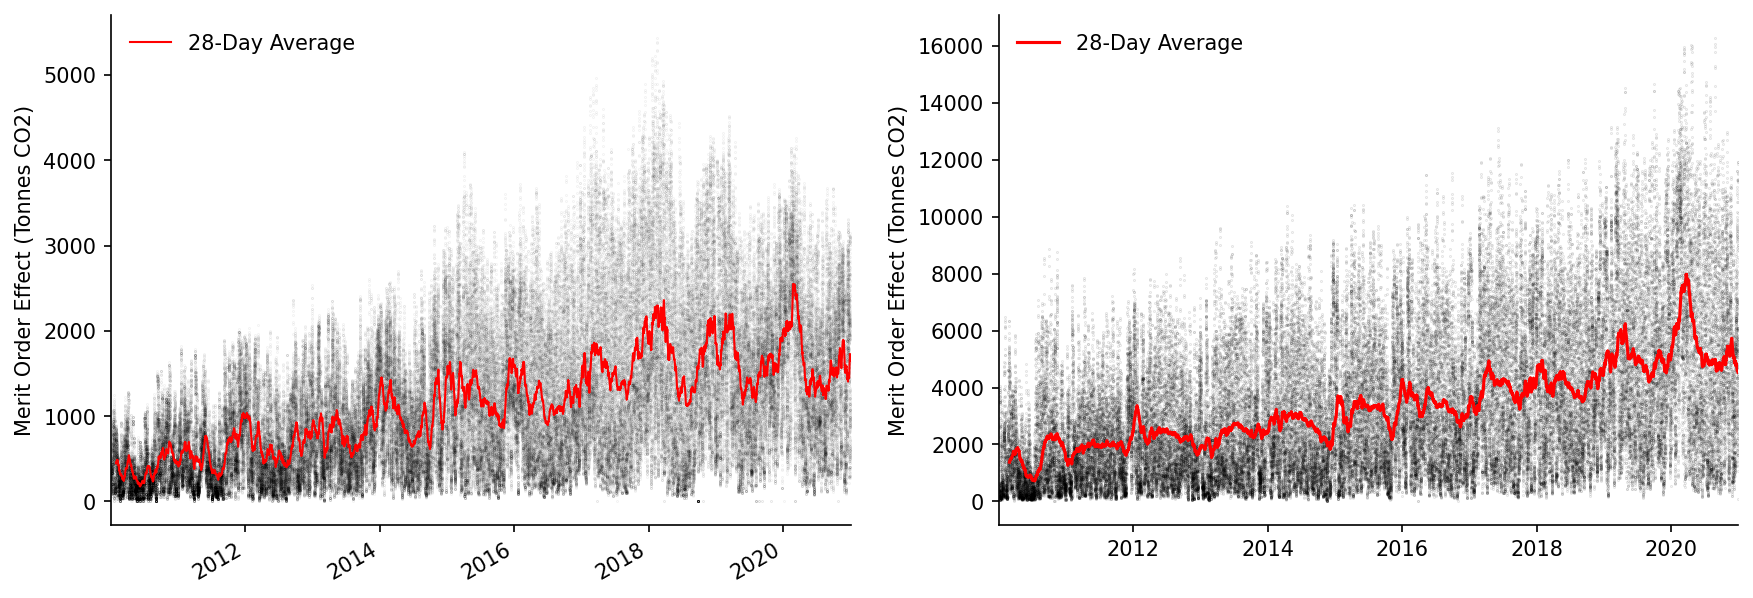

In [27]:
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(14, 5))

# GB
ax = axs[0]

ax.scatter(s_GB_MOE.index, s_GB_MOE, s=0.01, alpha=0.2, color='k', label=None)
s_GB_MOE_rolling.plot(color='r', linewidth=1, ax=ax, label='28-Day Average')

hlp.hide_spines(ax)
# ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (Tonnes CO2)')
ax.legend(frameon=False)

# DE
ax = axs[1]

ax.scatter(s_DE_MOE.index, s_DE_MOE, s=0.05, alpha=0.2, color='k', label=None)
ax.plot(s_DE_MOE_rolling.index, s_DE_MOE_rolling, color='r', linewidth=1.5, label='28-Day Average')

hlp.hide_spines(ax)
# ax.set_ylim(0, 80)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (Tonnes CO2)')
ax.legend(frameon=False)

<br>

### Saving Results

In [28]:
df_GB_results_ts = pd.DataFrame({
    'prediction': s_GB_pred_ts_dispatch,
    'counterfactual': s_GB_pred_ts_demand,
    'observed': df_GB.loc[s_GB_pred_ts_dispatch.index, 'emissions'],
    'moe': s_GB_MOE
})

df_GB_results_ts.head()

,prediction,counterfactual,observed,moe
local_datetime,,,,
2010-01-01 01:00:00+01:00,8414.720348,8861.950761,7949.2830,447.230413
2010-01-01 01:30:00+01:00,8535.217907,8986.131900,8030.2885,450.913993
2010-01-01 02:00:00+01:00,8414.720348,8820.732472,7974.9055,406.012124
2010-01-01 02:30:00+01:00,7983.815220,8454.751788,7707.5075,470.936568
2010-01-01 03:00:00+01:00,7645.468637,8060.813306,7456.1955,415.344669


In [29]:
df_GB_results_ts.to_csv('../data/results/GB_carbon.csv')

In [30]:
df_DE_results_ts = pd.DataFrame({
    'prediction': s_DE_pred_ts_dispatch,
    'counterfactual': s_DE_pred_ts_demand,
    'observed': df_DE.loc[s_DE_pred_ts_dispatch.index, 'emissions'],
    'moe': s_DE_MOE
})

df_DE_results_ts.head()

,prediction,counterfactual,observed,moe
local_datetime,,,,
2010-01-04 00:00:00+01:00,11981.637073,12178.996294,11883.81,197.359221
2010-01-04 01:00:00+01:00,11518.670361,11694.264437,11488.59,175.594076
2010-01-04 02:00:00+01:00,11400.534410,11577.437238,11228.52,176.902828
2010-01-04 03:00:00+01:00,11071.487432,11251.872193,10962.71,180.384761
2010-01-04 04:00:00+01:00,11311.483341,11518.670361,10892.45,207.187020


In [31]:
df_DE_results_ts.to_csv('../data/results/DE_carbon.csv')

In [32]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
Converted 04-surface-estimation.ipynb.
Converted 05-price-moe.ipynb.
Converted 06-carbon-moe.ipynb.
Converted 07-pred-conf-intvls.ipynb.
Converted 08-hyper-param-tuning.ipynb.
Converted 09-tables.ipynb.
